The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install d2l==0.17.1


# Linear Regression Implementation from Scratch
:label:`sec_linear_scratch`

Agora que você entende as principais ideias por trás da regressão linear,
podemos começar a trabalhar por meio de uma implementação prática no código.
Nesta seção, (**vamos implementar todo o método do zero,
incluindo o pipeline de dados, o modelo,
a função de perda e o otimizador de descida gradiente estocástico do minibatch.**)
Embora as estruturas modernas de *deep learning* possam automatizar quase todo esse trabalho,
implementar coisas do zero é a única maneira
para ter certeza de que você realmente sabe o que está fazendo.
Além disso, quando chega a hora de personalizar modelos,
definindo nossas próprias camadas ou funções de perda,
entender como as coisas funcionam nos bastidores será útil.
Nesta seção, contaremos apenas com tensores e diferenciação automática.
Posteriormente, apresentaremos uma implementação mais concisa,
aproveitando sinos e assobios de *frameworks* de *deep learning*.


In [1]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l

## Gerando o Dataset

Para manter as coisas simples, iremos [**construir um conjunto de dados artificial
de acordo com um modelo linear com ruído aditivo.**]
Nossa tarefa será recuperar os parâmetros deste modelo
usando o conjunto finito de exemplos contidos em nosso conjunto de dados.
Manteremos os dados em baixa dimensão para que possamos visualizá-los facilmente.
No seguinte *snippet* de código, geramos um conjunto de dados
contendo 1000 exemplos, cada um consistindo em 2 *features*
amostrado a partir de uma distribuição normal padrão.
Assim, nosso conjunto de dados sintético será uma matriz
$\mathbf{X}\in\mathbb{R}^{1000\times 2}$.

(**Os verdadeiros parâmetros que geram nosso conjunto de dados serão
$\mathbf{w} = [2, -3,4]^\top$ e $b = 4,2$,
e**) nossos rótulos sintéticos serão atribuídos de acordo
ao seguinte modelo linear com o termo de ruído $\epsilon$:

(**$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \mathbf\epsilon.$$**)

Você pode pensar em $\epsilon$ como um potencial de captura
erros de medição nos recursos e rótulos.
Vamos assumir que as premissas padrão são válidas e, portanto,
que $\epsilon$ obedece a uma distribuição normal com média 0.
Para tornar nosso problema mais fácil, definiremos seu desvio padrão em 0,01.
O código a seguir gera nosso conjunto de dados sintético.


In [2]:
def synthetic_data(w, b, num_examples):  #@save
    """Generate y = Xw + b + noise."""
    X = tf.zeros((num_examples, w.shape[0]))
    X += tf.random.normal(shape=X.shape)
    y = tf.matmul(X, tf.reshape(w, (-1, 1))) + b
    y += tf.random.normal(shape=y.shape, stddev=0.01)
    y = tf.reshape(y, (-1, 1))
    return X, y

In [3]:
true_w = tf.constant([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Observe que [**cada linha em `features` consiste em um exemplo de dados bidimensionais
e que cada linha em `labels` consiste em um valor de rótulo unidimensional (um escalar).**]


In [4]:
print('features:', features[0],'\nlabel:', labels[0])

features: tf.Tensor([1.1301318  0.14684609], shape=(2,), dtype=float32) 
label: tf.Tensor([5.960015], shape=(1,), dtype=float32)


Ao gerar um gráfico de dispersão usando o segundo recurso `features [:, 1]` e `labels`,
podemos observar claramente a correlação linear entre os dois.


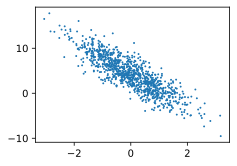

In [5]:
d2l.set_figsize()
# The semicolon is for displaying the plot only
d2l.plt.scatter(features[:, (1)].numpy(), labels.numpy(), 1);

## Lendo o *Dataset*


Lembre-se de que os modelos de treinamento consistem em
fazer várias passagens sobre o *dataset*,
pegando um *minibatch* de exemplos por vez,
e usando-los para atualizar nosso modelo.
Uma vez que este processo é tão fundamental
para treinar algoritmos de a*machine learning*,
vale a pena definir uma função de utilidade
para embaralhar o conjunto de dados e acessá-lo em *minibatches*.

No código a seguir, nós [**definimos a função `data_iter`**] (~~que~~)
para demonstrar uma possível implementação dessa funcionalidade.
A função (**leva um tamanho de amostra, uma matriz de *features*,
e um vetor de *labels*, produzindo *minibatches* do tamanho `batch_size`. **)
Cada *minibatch* consiste em uma tupla de *features* e *labels*.


In [6]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        j = tf.constant(indices[i: min(i + batch_size, num_examples)])
        yield tf.gather(features, j), tf.gather(labels, j)

Em geral, queremos usar *minibatches* de tamanhos razoáveis
para aproveitar as vantagens do hardware da GPU,
que se destaca em operações de paralelização.
Porque cada exemplo pode ser alimentado por meio de nossos modelos em paralelo
e o gradiente da função de perda para cada exemplo também pode ser tomado em paralelo,
GPUs nos permitem processar centenas de exemplos em pouco mais tempo
do que pode demorar para processar apenas um único exemplo.

Para construir alguma intuição, vamos ler e imprimir
o primeiro pequeno lote de exemplos de dados.
A forma dos recursos em cada *minibatch* nos diz
o tamanho do *minibatch* e o número de recursos de entrada.
Da mesma forma, nosso *minibatch* de rótulos terá uma forma dada por `batch_size`.


In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tf.Tensor(
[[-0.5730527   0.7819388 ]
 [-1.4290377   0.501779  ]
 [-1.0716456  -0.3164782 ]
 [-0.7258405   0.5719521 ]
 [ 1.7161779  -0.6173083 ]
 [-1.5024987   1.2860105 ]
 [ 0.5211034  -1.16397   ]
 [ 0.5002108  -0.70382583]
 [ 0.2605837   1.0829461 ]
 [ 0.4482001  -0.56022495]], shape=(10, 2), dtype=float32) 
 tf.Tensor(
[[ 0.38191256]
 [-0.36548588]
 [ 3.1524463 ]
 [ 0.80933195]
 [ 9.73811   ]
 [-3.1788385 ]
 [ 9.195568  ]
 [ 7.5800247 ]
 [ 1.0323184 ]
 [ 7.0033584 ]], shape=(10, 1), dtype=float32)


Conforme executamos a iteração, obtemos *minibatches* distintos
sucessivamente até que todo o conjunto de dados se esgote (tente isto).
Embora a iteração implementada acima seja boa para fins didáticos,
é ineficiente de maneiras que podem nos colocar em apuros em problemas reais.
Por exemplo, requer que carreguemos todos os dados na memória
e que realizamos muitos acessos aleatórios à memória.
Os iteradores integrados implementados em uma estrutura de *deep learning*
são consideravelmente mais eficientes e podem lidar
com dados armazenados em arquivos e dados alimentados por meio de fluxos de dados.


## Initializing Model Parameters

[**Antes de começarmos a otimizar os parâmetros do nosso modelo**] por gradiente descendente estocástico de *minibatch*,
(**precisamos ter alguns parâmetros em primeiro lugar.**)
No código a seguir, inicializamos os pesos por amostragem
números aleatórios de uma distribuição normal com média 0
e um desvio padrão de 0,01, e definindo a tendência para 0.


In [8]:
w = tf.Variable(tf.random.normal(shape=(2, 1), mean=0, stddev=0.01),
                trainable=True)
b = tf.Variable(tf.zeros(1), trainable=True)

Depois de inicializar nossos parâmetros,
nossa próxima tarefa é atualizá-los até
eles se ajustam aos nossos dados suficientemente bem.
Cada atualização requer a obtenção do gradiente
da nossa função de perda no que diz respeito aos parâmetros.
Dado este gradiente, podemos atualizar cada parâmetro
na direção que pode reduzir a perda.

Uma vez que ninguém quer calcular gradientes explicitamente
(isso é entediante e sujeito a erros),
usamos diferenciação automática,
conforme apresentado em :numref:`sec_autograd`, para calcular o gradiente.


## Definindo o Modelo

Em seguida, devemos [**definir nosso modelo,
relacionando suas entradas e parâmetros com suas saídas.**]
Lembre-se de que, para calcular a saída do modelo linear,
simplesmente pegamos o produto escalar vetor-matriz
dos recursos de entrada $\mathbf{X}$ e os pesos do modelo $\mathbf{w}$,
e adicione o *offset* $b$ a cada exemplo.
Observe que abaixo de $\mathbf{Xw}$ está um vetor e $b$ é um escalar.
Lembre-se do mecanismo de transmissão conforme descrito em :numref:`subsec_broadcasting`.
Quando adicionamos um vetor e um escalar,
o escalar é adicionado a cada componente do vetor.


In [9]:
def linreg(X, w, b):  #@save
    """The linear regression model."""
    return tf.matmul(X, w) + b

## Definindo a Função de Perda

Uma vez que [**atualizar nosso modelo requer tomar
o gradiente de nossa função de perda,**]
devemos (**definir a função de perda primeiro.**)
Aqui vamos usar a função de perda quadrada
conforme descrito em :numref:`sec_linear_regression`.
Na implementação, precisamos transformar o valor verdadeiro `y`
na forma do valor previsto `y_hat`.
O resultado retornado pela seguinte função
também terá a mesma forma de `y_hat`.


In [10]:
def squared_loss(y_hat, y):  #@save
    """Squared loss."""
    return (y_hat - tf.reshape(y, y_hat.shape)) ** 2 / 2

## Definindo o Algoritmo de Otimização


Como discutimos em :numref:`sec_linear_regression`,
a regressão linear tem uma solução de forma fechada.
No entanto, este não é um livro sobre regressão linear:
é um livro sobre *deep learning*.
Uma vez que nenhum dos outros modelos que este livro apresenta
pode ser resolvido analiticamente, aproveitaremos esta oportunidade para apresentar seu primeiro exemplo de trabalho de gradiente descendente estocástico de *minibatch*.
[~~Apesar da regressão linear ter uma solução de forma fechada, outros modelos neste livro não têm. Aqui, introduzimos o gradiente descendente estocástico de *minibatch*~~]

Em cada etapa, usando um *minibatch* retirado aleatoriamente de nosso conjunto de dados,
vamos estimar o gradiente da perda em relação aos nossos parâmetros.
A seguir, vamos atualizar nossos parâmetros
na direção que pode reduzir a perda.
O código a seguir aplica a atualização da descida gradiente estocástica do *minibatch*,
dado um conjunto de parâmetros, uma taxa de aprendizagem e um tamanho de *batch*.
O tamanho da etapa de atualização é determinado pela taxa de aprendizagem `lr`.
Como nossa perda é calculada como a soma do *minibatch* de exemplos,
normalizamos o tamanho do nosso passo pelo tamanho do *batch* (`batch_size`),
de modo que a magnitude de um tamanho de passo típico
não depende muito de nossa escolha do tamanho do lote.


In [11]:
def sgd(params, grads, lr, batch_size):  #@save
    """Minibatch stochastic gradient descent."""
    for param, grad in zip(params, grads):
        param.assign_sub(lr*grad/batch_size)

## Treinamento


Agora que temos todas as peças no lugar,
estamos prontos para [**implementar o *loop* de treinamento principal.**]
É crucial que você entenda este código
porque você verá loops de treinamento quase idênticos
repetidamente ao longo de sua carreira de *deep learning*.

Em cada iteração, pegaremos um *minibatch* de exemplos de treinamento,
e os passamos por nosso modelo para obter um conjunto de previsões.
Depois de calcular a perda, iniciamos a passagem para trás pela rede,
armazenando os gradientes em relação a cada parâmetro.
Finalmente, chamaremos o algoritmo de otimização de `sgd`
para atualizar os parâmetros do modelo.

Em resumo, vamos executar o seguinte loop:

* Inicializar parâmetros $(\mathbf{w}, b)$
* Repetir até terminar
    * Computar gradiente $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Atualizar parâmetros $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$

Em cada *época*,
iremos iterar por todo o conjunto de dados
(usando a função `data_iter`) uma vez
passando por todos os exemplos no conjunto de dados de treinamento
(assumindo que o número de exemplos seja divisível pelo tamanho do lote).
O número de épocas `num_epochs` e a taxa de aprendizagem` lr` são hiperparâmetros,
que definimos aqui como 3 e 0,03, respectivamente.
Infelizmente, definir hiperparâmetros é complicado
e requer alguns ajustes por tentativa e erro.
Excluímos esses detalhes por enquanto, mas os revisamos
mais tarde em
:numref:`chap_optimization`.


In [12]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [13]:
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with tf.GradientTape() as g:
            l = loss(net(X, w, b), y)  # Minibatch loss in `X` and `y`
        # Compute gradient on l with respect to [`w`, `b`]
        dw, db = g.gradient(l, [w, b])
        # Update parameters using their gradient
        sgd([w, b], [dw, db], lr, batch_size)
    train_l = loss(net(features, w, b), labels)
    print(f'epoch {epoch + 1}, loss {float(tf.reduce_mean(train_l)):f}')

epoch 1, loss 0.034802
epoch 2, loss 0.000124


epoch 3, loss 0.000052


Neste caso, porque nós mesmos sintetizamos o conjunto de dados,
sabemos exatamente quais são os verdadeiros parâmetros.
Assim, podemos [**avaliar nosso sucesso no treinamento
comparando os parâmetros verdadeiros
com aqueles que aprendemos**] através de nosso ciclo de treinamento.
Na verdade, eles acabam sendo muito próximos um do outro.


In [14]:
print(f'error in estimating w: {true_w - tf.reshape(w, true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: [ 0.00061536 -0.00040913]
error in estimating b: [-0.00094461]


Observe que não devemos tomar isso como garantido
que somos capazes de recuperar os parâmetros perfeitamente.
No entanto, no *machine learning*, normalmente estamos menos preocupados
com a recuperação de verdadeiros parâmetros subjacentes,
e mais preocupados com parâmetros que levam a previsões altamente precisas.
Felizmente, mesmo em problemas de otimização difíceis,
o gradiente descendente estocástico pode muitas vezes encontrar soluções notavelmente boas,
devido em parte ao fato de que, para redes profundas,
existem muitas configurações dos parâmetros
que levam a uma previsão altamente precisa.


## Resumo

* Vimos como uma rede profunda pode ser implementada e otimizada do zero, usando apenas tensores e diferenciação automática, sem a necessidade de definir camadas ou otimizadores sofisticados.
* Esta seção apenas arranha a superfície do que é possível. Nas seções a seguir, descreveremos modelos adicionais com base nos conceitos que acabamos de apresentar e aprenderemos como implementá-los de forma mais concisa.


## Exercícios

1. O que aconteceria se inicializássemos os pesos para zero. O algoritmo ainda funcionaria?
1. Suponha que você seja
    [Georg Simon Ohm](https://en.wikipedia.org/wiki/Georg_Ohm) tentando inventar um modelo entre tensão e corrente. Você poderia usar a diferenciação automática para aprender os parâmetros do seu modelo?
1. Você pode usar a [Lei de Planck](https://en.wikipedia.org/wiki/Planck%27s_law) para determinar a temperatura de um objeto usando densidade de energia espectral?
1. Quais são os problemas que você pode encontrar se quiser calcular as derivadas secundárias? Como você os consertaria?
1. Por que a função `reshape` é necessária na função` squared_loss`?
1. Experimente usar diferentes taxas de aprendizagem para descobrir a rapidez com que o valor da função de perda diminui.
1. Se o número de exemplos não pode ser dividido pelo tamanho do lote, o que acontece com o comportamento da função `data_iter`?


[Discussions](https://discuss.d2l.ai/t/201)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTMyODI5MzE5NSwtMTYzNTkwMDA0Myw4MT
EzMTUxOTQsMTYwOTI1NjAxLC0xMzQ1MjY5NzA5LDE0OTY1OTE3
MCwtMTk5MzU2NjkzLC05ODg5NjkwMTYsLTEyMjk2NzU0OTddfQ
==
-->
